# Best performing model on natural scenes was 8 conv + 16 affine. Visualize it!

In [1]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
import deepretina.visualizations as viz
from deepretina.preprocessing import datagen, loadexpt
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [4]:
architecture_filename = 'architecture.json'
whitenoise_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/')
whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out

#### Load white noise model

In [5]:
whitenoise_architecture_data = open(whitenoise_data_dir + architecture_filename, 'r')
whitenoise_architecture_string = whitenoise_architecture_data.read()
whitenoise_model = model_from_json(whitenoise_architecture_string)
whitenoise_model.load_weights(whitenoise_data_dir + whitenoise_weight_filename)

In [6]:
whitenoise_weights = h5py.File(whitenoise_data_dir + whitenoise_weight_filename, 'r')
list(whitenoise_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

#### Load natural scenes model

In [7]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

In [8]:
naturalscenes_weights = h5py.File(naturalscenes_data_dir + naturalscenes_weight_filename, 'r')
list(naturalscenes_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

# Cross-stimuli testing

In [54]:
naturalscenes_test = loadexpt(0, 'naturalscene', 'test', 40)
whitenoise_test = loadexpt(0, 'whitenoise', 'test', 40)

Loading testing data... Done.
Loading testing data... Done.


In [9]:
whitenoise_truth = []
naturalscenes_truth = []
whitenoise_on_whitenoise = []
whitenoise_on_naturalscenes = []
naturalscenes_on_whitenoise = []
naturalscenes_on_naturalscenes = []

### Test on white noise

In [10]:
for X, y in datagen(50, *whitenoise_test):
    whitenoise_truth.extend(y[)
    whitenoise_on_whitenoise.extend(whitenoise_model.predict(X))
    naturalscenes_on_whitenoise.extend(naturalscenes_model.predict(X))

#### Performance on white noise

Trained on white noise

In [22]:
whitewhite_performance = pearsonr(np.array(whitenoise_truth), np.array(whitenoise_on_whitenoise).squeeze())[0]
whitewhite_performance

0.62972344335667296

Trained on natural scenes

In [24]:
naturalwhite_performance = pearsonr(np.array(whitenoise_truth), np.array(naturalscenes_on_whitenoise).squeeze())[0]
naturalwhite_performance

0.36232118323330381

#### Test on natural scenes

In [19]:
for X, y in datagen(50, *naturalscenes_test):
    naturalscenes_truth.extend(y)
    whitenoise_on_naturalscenes.extend(whitenoise_model.predict(X))
    naturalscenes_on_naturalscenes.extend(naturalscenes_model.predict(X))

Trained on natural scenes

In [26]:
naturalnatural_performance = pearsonr(np.array(naturalscenes_truth), np.array(naturalscenes_on_naturalscenes).squeeze())[0]
naturalnatural_performance

0.52924176909365372

Trained on white noise

In [27]:
whitenatural_performance = pearsonr(np.array(naturalscenes_truth), np.array(whitenoise_on_naturalscenes).squeeze())[0]
whitenatural_performance

0.39040872985185721

So the model trained on white noise seems to generalize better than the model trained on natural scenes.

(0.3, 0.7)

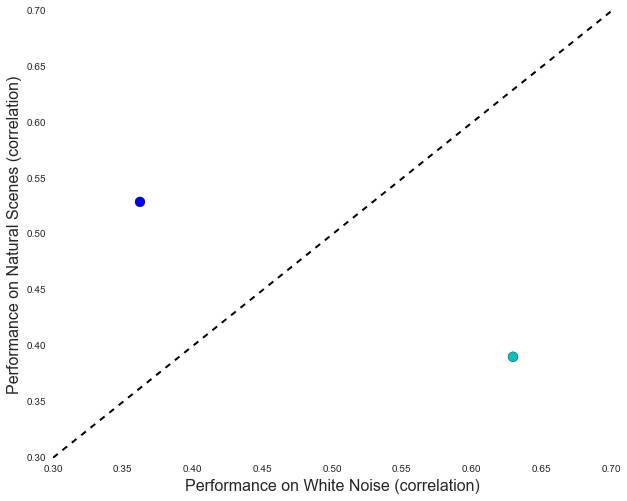

In [40]:
# plt natural scenes performance against white noise performance
plt.scatter([whitewhite_performance, naturalwhite_performance], 
            [whitenatural_performance, naturalnatural_performance], c=['c', 'b'], s=100)
plt.plot(np.linspace(0.3, 0.7, 4), np.linspace(0.3, 0.7, 4), 'k--', linewidth=2)
plt.xlabel('Performance on White Noise (correlation)', fontsize=16)
plt.ylabel('Performance on Natural Scenes (correlation)', fontsize=16)
plt.xlim([0.3, 0.7])
plt.ylim([0.3, 0.7])

# Filter differences between natural scenes and white noise models

#### Filters for model trained on white noise

Convnet weights

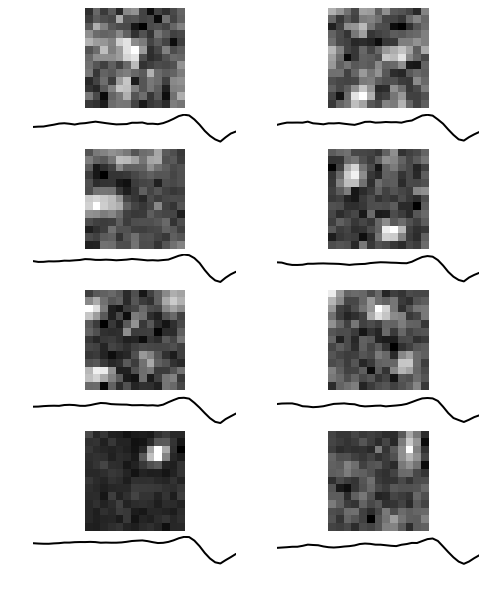

In [42]:
whitenoise_W0 = whitenoise_weights['layer_0']['param_0']
viz.visualize_convnet_weights(whitenoise_W0, title='convnet', fig_size=(8,10), dpi=500, space=True, time=True, 
                              display=True, save=False)

Affine weights

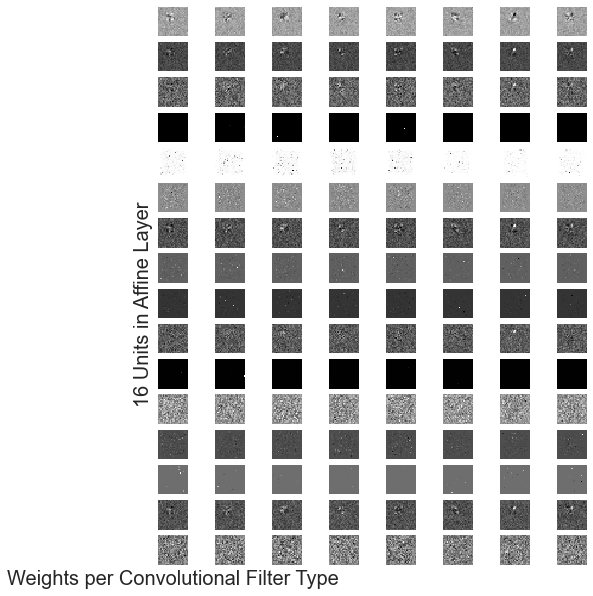

In [49]:
whitenoise_W3 = whitenoise_weights['layer_3']['param_0']
viz.visualize_affine_weights(whitenoise_W3, 8, title='affine', fig_size=(8,10), dpi=500, display=True, save=False)

#### Filters for model trained on natural scenes

Convnet filters

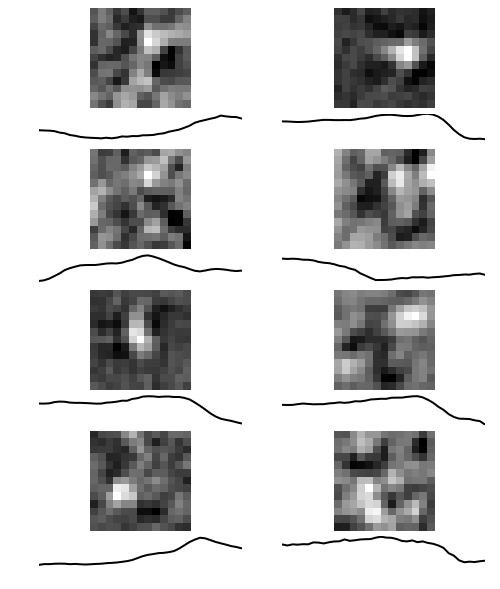

In [43]:
naturalscenes_W0 = naturalscenes_weights['layer_0']['param_0']
viz.visualize_convnet_weights(naturalscenes_W0, title='convnet', fig_size=(8,10), dpi=500, space=True, time=True, 
                              display=True, save=False)

Affine weights

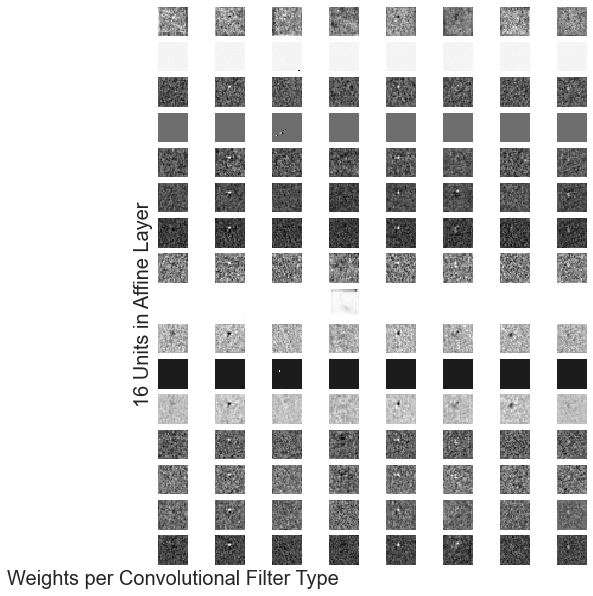

In [50]:
naturalscenes_W3 = naturalscenes_weights['layer_3']['param_0']
viz.visualize_affine_weights(naturalscenes_W3, 8, title='affine', fig_size=(8,10), dpi=500, display=True, save=False)

# White noise analysis

In [22]:
layer_id = 3
model = whitenoise_model
batch_size = 50

In [23]:
get_activations = theano.function([model.layers[0].input], model.layers[layer_id].get_output(train=False))

In [24]:
whitenoise_batch = np.random.randint(0,2,(batch_size,40,50,50)).astype('uint8')
response = get_activations(whitenoise_batch)

In [27]:
stas = {}

In [25]:
response.shape

(50, 16)

In [26]:
response.shape

(50, 16)

In [ ]:
get_activations = theano.function([model.layers[0].input], model.layers[layer_id].get_output(train=False))

# Initialize STA
sta = np.zeros((40, 50, 50), dtype='float')

# Generate white noise and map STA
for batch in range(int(np.ceil(samples/batch_size))):
    whitenoise = np.random.randn(batch_size, 40, 50, 50)
    response = get_activations(whitenoise)

    nonzero_inds = np.where(response > 0)[0]
    for idx in nonzero_inds:
        sta += response[idx] * whitenoise[idx]

sta /= samples
return sta

In [36]:
def get_sta(model, layer_id, samples=50000, batch_size=50):
    '''
    White noise STA of an intermeidate unit.
    '''
    # Get function for generating responses of intermediate unit.
    get_activations = theano.function([model.layers[0].input], model.layers[layer_id].get_output(train=False))

    impulse = np.random.randn(2, 40, 50, 50).astype('uint8')
    impulse_response = get_activations(impulse)
    impulse_response_flat = impulse_response.reshape(2, -1).T
    impulse_flat = impulse.reshape(2, -1)
    #num_filter_types = impulse_response.shape[1]
    sta = np.zeros_like(np.dot(impulse_response_flat, impulse_flat))

    # Initialize STA
    #stas = [np.zeros((40, 50, 50), dtype='float') for _ in range(num_stas)]
    stas = {}

    # Generate white noise and map STA
    for batch in range(int(np.ceil(samples/batch_size))):
        whitenoise = np.random.randn(batch_size, 40, 50, 50)
        response = get_activations(whitenoise)
        true_response_shape = response.shape[1:]

        response_flat = response.reshape(batch_size, -1).T
        whitenoise_flat = whitenoise.reshape(batch_size, -1)
        # sta will be matrix of units x sta dims
        sta += np.dot(response_flat, whitenoise_flat)
        #sta = sta.reshape((*true_response_shape, -1))

        #for dim in true_response_shape:


        #for filt_type in range(num_stas):
        #    nonzero_inds = np.where(response

        #nonzero_inds = np.where(response > 0)[0]
        #for idx in nonzero_inds:
        #    sta += response[idx] * whitenoise[idx]
    
    sta /= samples
    sta = sta.reshape((*true_response_shape, -1))
    return sta

In [38]:
whitenoise_sta = get_sta(whitenoise_model, 0, samples=1000)

RuntimeError: GpuCorrMM encountered a CUBLAS error: the function failed to launch on the GPU
This could be a known bug in CUDA, please see the GpuCorrMM() documentation.

Apply node that caused the error: GpuCorrMM_gradInputs{valid, (1, 1)}(GpuContiguous.0, GpuContiguous.0)
Toposort index: 11
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(40, 8, 13, 13), (2, 40, 50, 50)]
Inputs strides: [(1352, 169, 13, 1), (100000, 2500, 50, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuSubtensor{::, ::, int64:int64:, int64:int64:}(GpuCorrMM_gradInputs{valid, (1, 1)}.0, Constant{6}, ScalarFromTensor.0, Constant{6}, ScalarFromTensor.0)]]

Debugprint of the apply node: 
GpuCorrMM_gradInputs{valid, (1, 1)} [@A] <CudaNdarrayType(float32, 4D)> ''   
 |GpuContiguous [@B] <CudaNdarrayType(float32, 4D)> ''   
 | |GpuDimShuffle{1,0,2,3} [@C] <CudaNdarrayType(float32, 4D)> ''   
 |   |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>
 |GpuContiguous [@E] <CudaNdarrayType(float32, 4D)> ''   
   |GpuFromHost [@F] <CudaNdarrayType(float32, 4D)> ''   
     |<TensorType(float32, 4D)> [@G] <TensorType(float32, 4D)>

Storage map footprint:
 - GpuContiguous.0, Shape: (2, 40, 50, 50), ElemSize: 4 Byte(s), TotalSize: 800000 Byte(s)
 - <TensorType(float32, 4D)>, Input, Shape: (2, 40, 50, 50), ElemSize: 4 Byte(s), TotalSize: 800000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (8, 40, 13, 13), ElemSize: 4 Byte(s), TotalSize: 216320 Byte(s)
 - GpuContiguous.0, Shape: (40, 8, 13, 13), ElemSize: 4 Byte(s), TotalSize: 216320 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (8,), ElemSize: 4 Byte(s), TotalSize: 32 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - CudaNdarrayConstant{error while transferring the value: error (unspecified launch failure)copying data to host}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 TotalSize: 2032692.0 Byte(s) 0.002 GB
 TotalSize inputs: 1016372.0 Byte(s) 0.001 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [39]:
get_activations = theano.function([model.layers[0].input], model.layers[layer_id].get_output(train=False))

ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR:theano.gof.opt:Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: GpuFromHost(TensorConstant{(1, 1) of 0.5})
ERROR:theano.gof.opt:node: GpuFromHost(TensorConstant{(1, 1) of 0.5})
ERROR (theano.gof.opt): TRACEBACK:
ERROR:theano.gof.opt:TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/Theano-0.7.0-py2.7.egg/theano/gof/opt.py", line 1787, in process_node
    replacements = lopt.transform(node)
  File "/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/Theano-0.7.0-py2.7.egg/theano/tensor/opt.py", line 5554, in constant_folding
    required = thunk()
  File "/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/Theano-0.7.0-py2.7.egg/theano/gof/op.py", line 840, in rval
    fill_storage()
  File "/Library/Frameworks/EPD64.framework/Versio

# Placement of thresholds

In [55]:
whitenoise_W0.shape

(8, 40, 13, 13)

In [57]:
whitenoise_b0 = whitenoise_weights['layer_0']['param_1']
naturalscenes_b0 = naturalscenes_weights['layer_0']['param_1']

In [86]:
# modelstimuli_responses
whitewhite_responses = []
whitenatural_responses = []
naturalwhite_responses = []
naturalnatural_responses = []

Get responses to white noise

In [62]:
X.shape

(50, 40, 50, 50)

In [71]:
tmp = viz.response_before_threshold(weights['layer_0'], whitenoise_model, 0, X)

AttributeError: 'module' object has no attribute 'response_before_threshold'

In [87]:
for X, y in datagen(50, *whitenoise_test):
    flat_stim = X.reshape((X.shape[0], -1))
    flat_filters = [np.reshape(filt, -1) for filt in whitenoise_W0]
    responses = [np.dot(flat_stim, flat_filt) + whitenoise_b0[idx] for idx, flat_filt in enumerate(flat_filters)]
    whitewhite_responses.extend(responses[0])
    #whitewhite_responses[filt_type].extend(
    #for filt_type in range(whitenoise_W0.shape[0]):

ValueError: shapes (50,100000) and (6760,) not aligned: 100000 (dim 1) != 6760 (dim 0)

In [93]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D

In [96]:
def linear_model(weights):
    filters = weights['param_0']
    biases = weights['param_1']
    stim_shape = (40, 50, 50)
    model = Sequential()
    model.add(Convolution2D(filters.shape[0], filters.shape[-2], filters.shape[-1],
                                         input_shape=stim_shape, weights=[filters, biases],
                                         border_mode='same', subsample=(1,1)))
    model.compile()
    return model

In [97]:
linear_whitenoise_model = linear_model(whitenoise_weights['layer_0'])

MemoryError: ('Error allocating 216320 bytes of device memory (unspecified launch failure).', "you might consider using 'theano.shared(..., borrow=True)'")

In [ ]:
get_linear_activations = theano.function([model.layers[0].input], model.layers[layer_id].get_output(train=False))

In [90]:
whitenoise_model.layers[0].input

NameError: name 'model' is not defined